# Google ReCaptcha Image Solver Report

## Authors
- **Kianoosh Vadaei**: Researcher
- **Melika Shirian**: Researcher

### Contact Information
- Kianoosh Vadaei: [email](mailto:kia.vadaei@gmail.com), [LinkedIn](https://www.linkedin.com/in/kianoosh-vadaei-0aa58611b/), [GitHub](https://github.com/kia-vadaei)
- Melika Shirian: [email](mailto:mel.shirian@gmail.com), [LinkedIn](https://www.linkedin.com/in/melika-shirian-b8477a254/), [GitHub](https://github.com/MelikaShirian12)

## Introduction
This notebook provides an analysis of the **Google ReCaptcha Image** Solver. It is structured into three main parts:

1. Text Classification with Fine-tuning BERT Model:
   - Data Loading
   - Model Building
   - Model Evaluation

2. Applying YOLO on Captcha Images:
   - Object Detection
   - Image Processing

3. Integrating Text Classification with Object Detection:
   - Combined Approach
   - Analysis and Results

## Table of Contents
1. [Introduction](#Introduction)
2. [Text Classification with BERT](#Text-Classification-with-BERT)
   - [Data Loading](#Data-Loading)
   - [Model Building](#Model-Building)
   - [Model Evaluation](#Model-Evaluation)
3. [Applying YOLO on Captcha Images](#Applying-YOLO-on-Captcha-Images)
   - [Object Detection](#Object-Detection)
4. [Integrating Text Classification with Object Detection](#Integrating-Text-Classification-with-Object-Detection)
5. [Conclusion](#Conclusion)


Here we setup out kaggle token to access the dataset and unzip the image dataset


In [152]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [153]:
!kaggle datasets download -d sanjeetsinghnaik/google-recaptcha

Dataset URL: https://www.kaggle.com/datasets/sanjeetsinghnaik/google-recaptcha
License(s): MIT
google-recaptcha.zip: Skipping, found more recently modified local copy (use --force to force download)


In [154]:
import zipfile
zip_ref = zipfile.ZipFile('/content/google-recaptcha.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

Here we clone our github repository to load the text dataset

In [155]:
!git clone https://github.com/KIa-MEL/Google-ReCaptcha-CNN.git

fatal: destination path 'Google-ReCaptcha-CNN' already exists and is not an empty directory.


# Text-Classification-with-BERT

## Data Loading

Here we read the CSV text dataset that was generated by generating sentences using GPT and saving them to a CSV format. We separate the texts and labels for further processing.


In [156]:
import pandas as pd
df = pd.read_csv('Google-ReCaptcha-CNN/data/text-data.csv')
texts = df['sentences']
labels = df['labels']


In [157]:
df

,sentences,labels
0,A shiny red bicycle parked near the park entrance,bicycle
1,Two cyclists riding their bicycles down the mo...,bicycle
2,A child learning to ride a bicycle with traini...,bicycle
3,A group of friends cycling through the city st...,bicycle
4,A bicycle leaning against a tree in the backyard,bicycle
...,...,...
232,The traffic light was synchronized to improve ...,traffic light
233,"The traffic light turned amber, signaling driv...",traffic light
234,"A bus stopped abruptly at the traffic light, c...",traffic light
235,The traffic light swayed in the wind during th...,traffic light


Here, we separate the training and testing data to train the model on the training data and evaluate it on the test data.

In [158]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, shuffle=True, random_state=42)

train_labels = train_labels.tolist()
val_labels = val_labels.tolist()
train_texts = train_texts.tolist()
val_texts = val_texts.tolist()

As our labels are strings, here we encode the labels and create a dictionary for decoding the encoded labels.

In [159]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(train_labels)

label_decoder = {index: label for index, label in enumerate(label_encoder.classes_)}

In this cell, we utilize the `BertTokenizer` from the Hugging Face `transformers` library to tokenize our training texts. Tokenization is a crucial step in natural language processing (NLP) tasks, where text is split into meaningful units called tokens.

In [160]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)

In this cell, we define a custom dataset class `TextDataset` using PyTorch's `torch.utils.data.Dataset`. This class is designed to facilitate handling of text data for machine learning tasks, such as text classification or sequence modeling.

In [161]:
import torch

class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

dataset = TextDataset(encodings, labels)


In this cell, we create a `DataLoader` object using PyTorch's `DataLoader` module. `DataLoader` is a utility that provides an iterable over a given dataset, facilitating efficient batch processing during training or evaluation of machine learning models.


In [162]:
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

In this cell, we determine the device for computation using PyTorch based on availability of CUDA (GPU).

In [163]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Model-Building

In this cell, we initialize a BERT (Bidirectional Encoder Representations from Transformers) model for sequence classification using the Hugging Face `transformers` library and configure an AdamW optimizer for training.

In [164]:
from transformers import BertForSequenceClassification, AdamW

num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)
optimizer = AdamW(model.parameters(), lr=5e-5)

model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In this cell, we perform fine-tuning of a pre-trained BERT model for sequence classification using PyTorch. Fine-tuning involves adjusting the model's weights on a specific task using a smaller, task-specific dataset, often achieving improved performance compared to training from scratch.


In [165]:
from transformers import get_linear_schedule_with_warmup
from tqdm import *
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

epochs = 5
total_steps = len(dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

for epoch in range(epochs):
    model.train()
    for batch in dataloader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        scheduler.step()
        print(f'Loss: {loss.item():.4f}')

    print(f'Epoch {epoch + 1}/{epochs} completed.')


Loss: 2.5761
Loss: 2.6803
Loss: 2.4252
Loss: 2.4463
Loss: 2.4417
Loss: 2.5395
Loss: 2.3983
Loss: 2.0076
Loss: 2.6577
Loss: 2.5595
Loss: 2.2712
Loss: 2.3653
Loss: 2.4135
Loss: 2.3905
Loss: 2.2792
Loss: 2.5598
Loss: 2.1710
Loss: 2.4873
Loss: 2.5844
Loss: 2.3041
Loss: 2.3572
Loss: 2.2914
Loss: 2.0044
Loss: 2.2170
Loss: 2.5098
Loss: 1.8092
Loss: 2.1507
Loss: 2.1420
Loss: 2.0612
Loss: 2.3597
Loss: 2.1915
Loss: 1.9916
Loss: 2.0879
Loss: 1.7539
Loss: 2.3033
Loss: 1.8169
Loss: 1.6137
Loss: 2.2830
Loss: 2.0003
Loss: 1.5316
Loss: 1.6415
Loss: 1.7441
Loss: 1.8391
Loss: 2.1549
Loss: 1.6286
Loss: 2.1032
Loss: 1.8430
Loss: 1.8969
Epoch 1/5 completed.
Loss: 1.6421
Loss: 1.7436
Loss: 1.5224
Loss: 1.8465
Loss: 1.4099
Loss: 1.9416
Loss: 1.4482
Loss: 1.4668
Loss: 1.4923
Loss: 1.5897
Loss: 1.4994
Loss: 1.4970
Loss: 1.5373
Loss: 1.7520
Loss: 1.8246
Loss: 1.5729
Loss: 1.5737
Loss: 1.5901
Loss: 1.4558
Loss: 1.5163
Loss: 1.3255
Loss: 1.2528
Loss: 1.8417
Loss: 1.4740
Loss: 1.2957
Loss: 1.3867
Loss: 1.0463
Loss

# Model Evaluation

In this cell, we evaluate the performance of the fine-tuned BERT model on a validation dataset using the accuracy score metric.

In [166]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


val_labels = label_encoder.transform(val_labels)

val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)
val_dataset = TextDataset(val_encodings, val_labels)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

predictions = []
true_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        labels = labels.cpu().numpy()

        predictions.extend(preds)
        true_labels.extend(labels)

predicted_labels = label_encoder.inverse_transform(predictions)
true_labels_str = label_encoder.inverse_transform(true_labels)

accuracy = accuracy_score(true_labels_str, predicted_labels)
precision = precision_score(true_labels_str, predicted_labels, average='weighted')
recall = recall_score(true_labels_str, predicted_labels, average='weighted')
f1 = f1_score(true_labels_str, predicted_labels, average='weighted')

print(f'Validation Accuracy: {accuracy}')
print(f'Validation Precision: {precision}')
print(f'Validation Recall: {recall}')
print(f'Validation F1 Score: {f1}')

Validation Accuracy: 0.9583333333333334
Validation Precision: 0.9722222222222222
Validation Recall: 0.9583333333333334
Validation F1 Score: 0.9605413105413105


The `predict` function defined in this cell allows for making predictions with a fine-tuned BERT model on new text inputs.

In [167]:
def predict_text(text):

    encoding = tokenizer(text, truncation=True, padding=True, max_length=128, return_tensors='pt')

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_class_id = torch.argmax(logits, dim=1).cpu().numpy()[0]

    predicted_label = label_decoder[predicted_class_id]

    return predicted_label


Using the `predict` function, we analyze a piece of text that metaphorically describes progress and ascent without explicitly mentioning stairs:

In [168]:
predict_text("Ascending step by step, each rise marking progress, a journey upwards unfolds. Each level gained whispers of effort, of determination that lifts us higher. With each step forward, the horizon expands, beckoning us to new heights.")

'palm'

# Applying-YOLO-on-Captcha-Images

In this cell, we use `imutils.paths` from the `imutils` library along with OpenCV (`cv2`) to retrieve paths to images.

In [196]:
import imutils.paths as paths
import random
image_paths = list(paths.list_images('./data/train/Traffic Light'))

## Object-Detection

This cell loads necessary libraries and initializes a YOLOv5 model for object detection.


In [217]:
import cv2
import torch
from IPython.display import display
sample_image_path = random.sample(image_paths, 1)
yolo_model = torch.hub.load("ultralytics/yolov5", "yolov5s")

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-7-4 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


The `detect_captcha` function defined in this cell utilizes the YOLOv5 model to detect objects in an image, particularly focusing on captcha detection.

In [194]:
def detect_captcha(image_path, details=False):
  image = cv2.imread(image_path)

  results = yolo_model(image, size=200)

  results.print()
  results.show()
  if details:
    display(results.pandas().xyxy[0])
  return results.pandas().xyxy[0]['name'].tolist()

In this cell, a random image path is sampled from `image_paths`, and the `detect_captcha` function is utilized to predict and display captcha details.


image 1/1: 120x120 2 cars, 1 bus, 2 traffic lights
Speed: 1.0ms pre-process, 8.2ms inference, 1.5ms NMS per image at shape (1, 3, 224, 224)


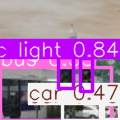

,xmin,ymin,xmax,ymax,confidence,class,name
0,80.195290,58.901283,92.483345,91.478081,0.842284,9,traffic light
1,58.171074,57.127880,73.098778,88.642403,0.772292,9,traffic light
2,62.393791,101.636070,103.218987,120.000000,0.468918,2,car
3,100.802078,104.354591,119.928795,119.966179,0.403218,2,car
4,0.000000,67.697670,111.256157,120.000000,0.325634,5,bus


In [212]:
sample_image_path = random.sample(image_paths, 1)
predected_image_labels = detect_captcha(sample_image_path[0], details=True)

# Integrating Text Classification with Object Detection

In this cell, we use the `predict_text` function to predict labels for sample texts and compare these predicted text labels with the detected image labels from the `detect_captcha` function.


In [216]:
sample_text1 = "At intersections, a beacon of order governs the flow of movement. It signals moments to pause and moments to proceed, guiding the rhythm of the city's pulse. Drivers and pedestrians alike await its silent command, respecting the invisible choreography it orchestrates. With its guidance, chaos transforms into coordinated motion, ensuring safe passage for all."
sample_text2 = "Moving through the city's veins, passengers are carried swiftly from stop to stop. Each stop brings new faces and stories, a dynamic flow through urban landscapes. Inside, conversations hum like a communal heartbeat, connecting diverse lives on a shared path of transit. Windows frame fleeting glimpses of familiar streets and unknown corners, a fleeting journey through the pulse of city life."

predected_text = predict_text(sample_text2).lower()

for predected_image_label in predected_image_labels:
  if(predected_image_label.lower() == predected_text):
    print("True")
    break
else:
    print("False")


True


# Conclusion

In this project, we successfully developed a system to analyze and solve Google ReCaptcha images using a combination of text classification and object detection techniques. We started by fine-tuning a BERT model for text classification, which enabled us to accurately predict labels for captcha-related text inputs. Concurrently, we employed the YOLOv5 model for object detection to identify and label objects within captcha images.

By integrating these two approaches, we created a robust mechanism to correlate text-based captcha prompts with corresponding image components, enhancing the overall accuracy and efficiency of the captcha-solving process. Our approach demonstrates the potential of combining state-of-the-art natural language processing and computer vision models to tackle complex, multi-modal problems.

Future work can focus on further optimizing the models for faster inference and exploring additional techniques to handle more diverse and challenging captcha types, ultimately improving the system's robustness and applicability in real-world scenarios.